# Tracking script

### Will be great to be it at a class
### Need to try it with real cells

In [1]:
%matplotlib inline

In [13]:
from tracking import *
from flatten_images import *
from skimage import io
from IPython.html.widgets import interact, fixed, IntSlider

In [3]:
img = io.imread("SwimmingAlgae.tif")

In [4]:
nt, ny, nx = img.shape

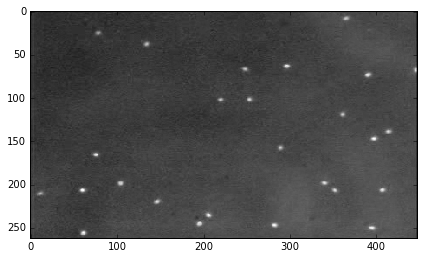

In [26]:
@interact(image = fixed(img), x=(0, nt-1, 1))
def show_frame(image, x=5):
    io.imshow(image[x,:,:])

In [5]:
img_divide = illumin_correct(img)

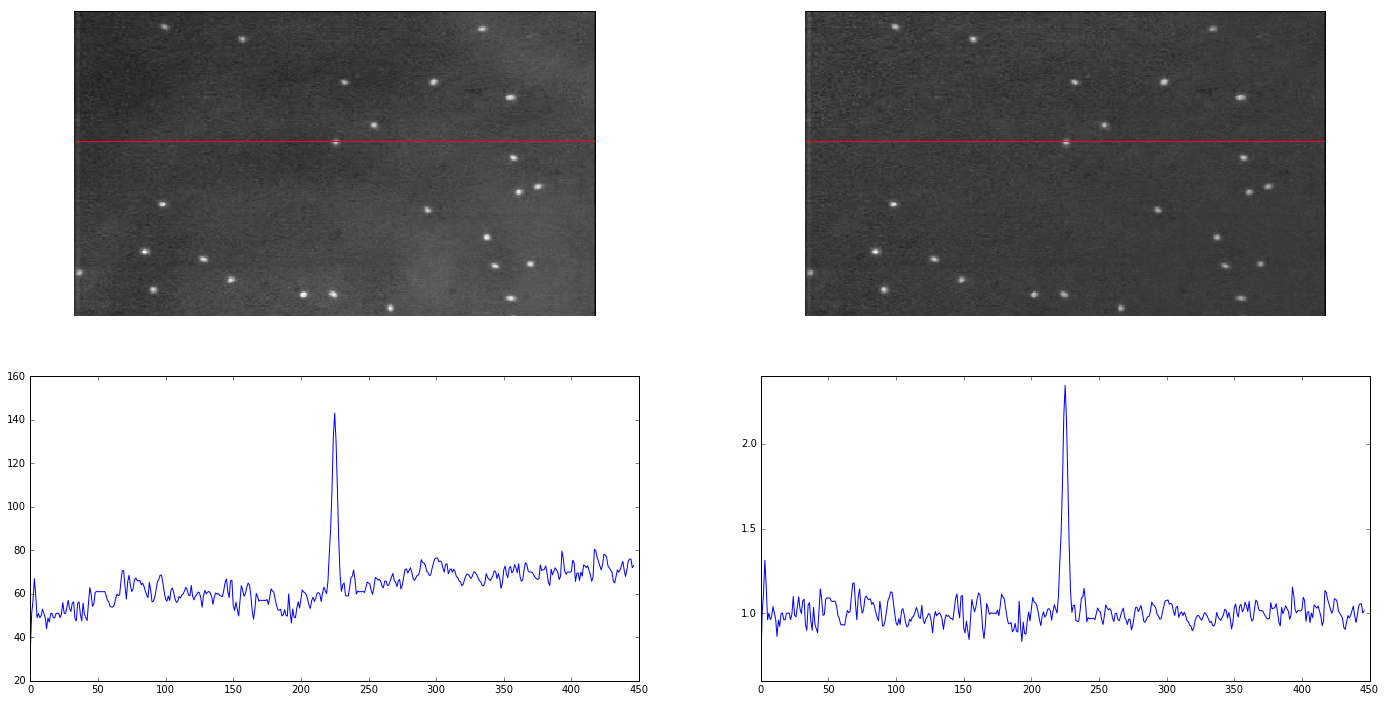

In [15]:
interact(plot_profile_corrected_image, img = fixed(img), img_divide = fixed(img_divide), 
         position = IntSlider(min=0,max=ny,step=1,value=50), 
         div = IntSlider(min=0,max=5,step=1,value=3))

In [7]:
local_maxima = Num_Blob(img_divide, nt)

In [8]:
liste_a = multiple_track_all(local_maxima, img)

## Plot

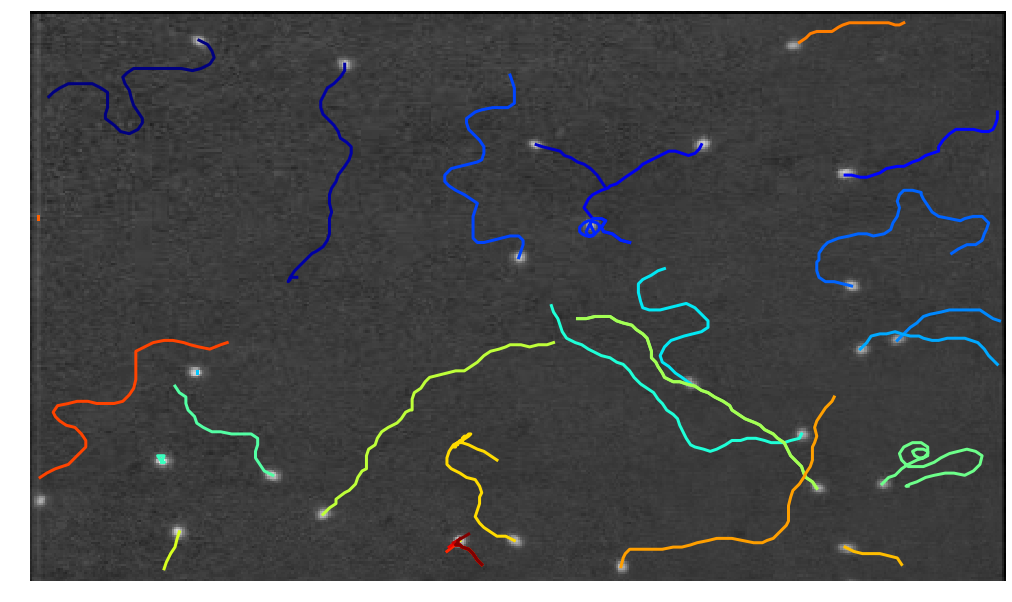

In [9]:

fig, axes = plt.subplots(1,1, figsize=(nx/15, ny/15))
axes.imshow(img_divide[0,:,:], cmap="gray",interpolation='nearest')

color=iter(plt.cm.jet(np.linspace(0,1,len(liste_a))))

for n in range(len(liste_a)):  
    c=next(color)
    axes.plot(liste_a[n][:,1], liste_a[n][:,0], linewidth=3, c=c)
axes.axis("off")
axes.autoscale_view('tight')

fig.savefig('Track_2D.png', bbox_inches='tight')

In [ ]:
# Plot the track in 3D
from mayavi import mlab
scene = mlab.figure(size = (1024,768), fgcolor=(0, 0, 0), bgcolor=(0.8, 0.8, 0.8))

arr = np.concatenate(liste_a[:], axis=0)
x = arr[:,1]
y = arr[:,0]
z = arr[:,2]
ax = mlab.plot3d(x,y, z, tube_radius=0)
ax = mlab.axes(zlabel="T")
ax.title_text_property.bold = False
ax.label_text_property.bold = False
ax.title_text_property.italic = False
ax.label_text_property.italic = False
ax.title_text_property.font_family = "times"
ax.label_text_property.font_family = "times"
ax.axes.font_factor=1
mlab.outline()

for n in range(len(liste_a)):
    x = liste_a[n][:,1]
    y = liste_a[n][:,0]
    z = liste_a[n][:,2]
    t = np.linspace(0, 20, len(z))
    exp = mlab.plot3d(x,y, z, t, tube_radius=2)

scene.scene.camera.position = [723.11244587305441, 595.11034212703476, 474.40094467678716]
scene.scene.camera.focal_point = [250.2378683140945, 122.2357645680766, 1.5263671178281939]
scene.scene.camera.view_angle = 30.0
scene.scene.camera.view_up = [0.0, 0.0, 1.0]
scene.scene.camera.clipping_range = [384.60043576038015, 1367.8917952716088]
scene.scene.camera.compute_view_plane_normal()
scene.scene.render()

#mlab.show()

arr = mlab.screenshot(mode='rgba')
mlab.close(scene)

fig, axes = plt.subplots(figsize=(24,24))
axes.axis("off")
axes.autoscale_view('tight')
axes.imshow(arr)

fig.savefig('Track_3D.png', bbox_inches='tight')

In [ ]:
import pandas as pd

In [ ]:
name =[]
i=0
for n in range(len(local_maxima[0])):
    i+=1
    name.append("cell_{}".format(i))
print(name)

In [ ]:
liste_dataframe =[]
for x in range(len(liste_a)):
    df = pd.DataFrame(liste_a[x], columns=["x", "y", "t"])
    liste_dataframe.append(df)
result = pd.concat(liste_dataframe,axis=0, keys=name) 

In [ ]:
def compute_msd(trajectory, t_step, coords=['x', 'y']):
    
    delays = trajectory['t']
    shifts = np.floor(delays/t_step).astype(np.int)
    msds = np.zeros(shifts.size)
    for i, shift in enumerate(shifts):
        diffs = trajectory[coords] - trajectory[coords].shift(-shift)
        sqdist = np.square(diffs).sum(axis=1)
        msds[i] = np.trim_zeros(sqdist).mean()
    return delays, msds


In [ ]:
fig, (ax) = plt.subplots(1, 1, figsize=(24, 16))
color=iter(plt.cm.jet(np.linspace(0,1,len(result.groupby(level=0)))))

for cell, new_df in result.groupby(level=0):
    c=next(color)
    delays, msds = compute_msd(new_df, t_step=1)
    ax.plot(delays, msds, '-r',label=cell, c=c)
    ax.legend(loc=2, ncol=2, fontsize=18)
    ax.set_title("Random movement", fontsize=18)
    ax.set_xlabel('Delay (s)', fontsize=18)
    ax.set_ylabel('MSD (µm²)', fontsize=18)
    
fig.savefig('MSD.png', bbox_inches='tight')